<a href="https://colab.research.google.com/github/vanderbilt-data-science/lo-achievement/blob/main/instructor_vector_store_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Shared Vector Store (for Instructors)

This notebook is for instructors to create a *vector store* which contains all of the information necessary for students to generate their own self-study materials using large language models.

## Using This Notebook
This notebook is split up into a bunch of *cells*, which contain explanations / instructions or code. You should go through the cells in order from top to bottom.

When you encounter a code cell, hover the mouse over it and press the 'run' button (the circle with a triangle inside of it) to execute the code in the cell. Wait until the green checkmark appears to the right of the run button before proceeding to the next cell.

Run the following code block to test it out. It should display `4` below the code.

*Note: Before running, there may be a pop-up saying 'Warning: This notebook was not authored by Google'. In that case, click 'Run anyways'.*

In [ ]:
print(2+2)

## Importing Libraries
Continue running the code below. Ignore any warnings that pop up.

In [ ]:
# install libraries here
# -q flag for "quiet" install
!pip install -q langchain openai unstructured tiktoken deeplake trafilatura justext yt_dlp pydub

In [ ]:
# import libraries here
import os

from google.colab import files
from getpass import getpass
from IPython.display import display, Markdown

import openai
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders.unstructured import UnstructuredFileLoader

from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser
from langchain.document_loaders.blob_loaders.youtube_audio import YoutubeAudioLoader

from langchain.document_loaders import WebBaseLoader
import trafilatura
import requests
import justext

import deeplake
from langchain.vectorstores import DeepLake

## Setting Up API Access
Much of the following code rely on certain *APIs* (application programming interfaces) which have limited access. You will need to get an *API key* for each of those services which will be inserted into the code to let the service know you are an authorized user.

#### OpenAI

First, you will need an **OpenAI API key**. To do this:
1. Visit [platform.openai.com/account/api-keys](https://platform.openai.com/account/api-keys) and sign up for an account.
2. Click 'Create a secret API key', and give it any name you want.
3. Copy the newly created key, either by right-clicking and pressing 'Copy' or using the keyboard shortcut -- Ctrl+C on Windows, Cmd+C on a Mac.

Run the following code cell. You'll see a blank text box pop up -- paste your API key there (using the shortcut Ctrl+V on Windows, or Cmd+V if you are using a Mac) and press Enter.

In [ ]:
OPENAI_API_KEY = getpass("OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

#### DeepLake

Next, you will need to input a **DeepLake API key**, found in the DeepLake dashboard at [app.activeloop.ai](https://app.activeloop.ai).

1. Click the link above and create an account.
2. After making an account, you will be prompted to set a username. Once you have set your username, copy it, run the code below, paste the username into the text box, and press Enter. (This username will be shared with students.)

In [ ]:
DEEPLAKE_USERNAME = input("DeepLake username: ")

3. You should then be on the DeepLake dashboard. At the top, click 'Create API token'. You should see an empty table with the columns 'Name', 'Expiration date', and 'Token'.
4. Click the 'Create API token' button 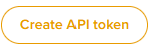 at the right of the page, choose a name for the token, then click 'Create API token'. (You do not need to change the expiration date.)
5. Afterwards, you should see the table look something like this:

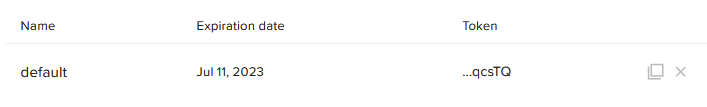

6. Click the two overlaid squares 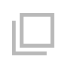 to copy the API key; then run the code below and paste it into the input text box and press Enter.

In [ ]:
os.environ['ACTIVELOOP_TOKEN'] = getpass("DeepLake API key: ")

Finally, pick a name for your dataset. It doesn't matter what this is, but keep in mind that it will be shared with the students.

In [ ]:
dataset_name = input("Enter a name for your dataset: ")

## Processing The Document(s)

In this part, you will upload the documents you want the students / model to reference; the embeddings will be created from those documents.

**Note: The embeddings of all the documents you share will be publicly available. Do not use this for any documents you want to keep private.**

First, upload your documents to Google Colab. To do this:
1. Click on the 'file' icon 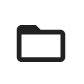 at the bottom of the sidebar to the left of these instructions.
2. Click on the 'upload file' icon 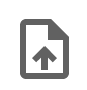 on the left of the Files toolbar.
3. Select all of the files you want to upload, then click 'Open'.
4. A warning should pop up. Click 'OK' to continue.
5. Wait until the spinning circle in the bottom of the 'Files' section disappears. This means that all of the files have been uploaded.

### Adding YouTube Videos / Websites
If you have any websites or YouTube videos which also contain content which you want to put into your data lake, paste those links one at a time into the text box below, pressing 'Enter' after each one. Once you have entered all the links, press 'Enter' without typing anything to finish execution of the code cell.

If you have no URLs to add, just click on the box and press 'Enter' without typing anything.

In [ ]:
url_list = []
while (url := input("Enter a YouTube / website link: ")): url_list.append(url)

## Embedding & Database Creation

Finally, run the following code.

In [ ]:
# Functions to extract the text from YouTube videos / websites
def save_text(text, text_name = None):
  if not text_name: text_name = text[:20]
  text_path = os.path.join("/content",text_name+".txt")
  with open(text_path, "x") as f:
    f.write(text)
  # Return the location at which the transcript is saved
  return text_path

def save_youtube_transcript(url, save_dir = "sample_data"):
  # Transcribe the videos to text and save to file in /content
  # save_dir: directory to save audio files
  youtube_loader = GenericLoader(YoutubeAudioLoader([url], save_dir),
                                 OpenAIWhisperParser())
  youtube_docs = youtube_loader.load()
  # Combine doc
  combined_docs = [doc.page_content for doc in youtube_docs]
  text = " ".join(combined_docs)
  # Save text to file
  video_path = youtube_docs[0].metadata["source"]
  youtube_name = os.path.splitext(os.path.basename(video_path))[0]
  return save_text(text, youtube_name)

# Multiple ways of extracting web content

def website_webbase(url):
  website_loader = WebBaseLoader(url)
  website_data = website_loader.load()
  # Combine doc
  combined_docs = [doc.page_content for doc in website_data]
  text = " ".join(combined_docs)
  return text

def website_trafilatura(url):
  downloaded = trafilatura.fetch_url(url)
  return trafilatura.extract(downloaded)

def website_justext(url):
  response = requests.get(url)
  paragraphs = justext.justext(response.content, justext.get_stoplist("English"))
  content = [paragraph.text for paragraph in paragraphs \
            if not paragraph.is_boilerplate]
  text = " ".join(content)
  return text

def get_website_youtube_text_file(urls):
  for url in urls:
    # This is a bit of a hacky way to determine whether it's youtube video
    if "youtube.com" in url or "youtu.be" in url: save_youtube_transcript(url)
    else: save_text(website_webbase(url))

In [ ]:
get_website_youtube_text_file(url_list)

In [ ]:
### Embedding Creation ###

# See https://github.com/hwchase17/langchain/discussions/3786
# for discussion of which splitter to use
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)

all_document_segments = []
print("The following files have been uploaded:")
for filename in os.listdir():
  if filename not in [".config", "sample_data"]:
    print("\t"+filename)
    loader = UnstructuredFileLoader(filename)
    documents = loader.load()
    document_segments = text_splitter.split_documents(documents)
    all_document_segments.extend(document_segments)

Make sure that all of your documents are shown in the output from the previous code cell, then continue execution.

In [ ]:
model_name = 'text-embedding-ada-002'
model_embedding_dimension = 1536

embeddings = OpenAIEmbeddings(
    model=model_name
)

In [ ]:
### Dataset Creation ###
dataset_path = f"hub://{DEEPLAKE_USERNAME}/{dataset_name}"
db = DeepLake.from_documents(all_document_segments, dataset_path=dataset_path,
                             embedding=embeddings, public=True)

### Sharing With Students

In [ ]:
display(Markdown(f'''To let students access the repository, give them the following URL:

`{dataset_path}`'''))

Distribute the URL above to students. They will copy and paste it into the LLM learning application, which then allows their models to use all of the documents you uploaded as reference sources when responding to or creating questions.